In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# 주피터 노트북 사용 시 그래프를 내부에 출력하기 위한 설정
%matplotlib inline

# 1. features.txt 파일 로드
# sep='\s+'는 공백이 하나 이상인 경우를 구분자로 사용한다는 의미입니다.
feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+', 
                              header=None, names=['column_index', 'column_name'])

# 2. 피처명만 추출하여 리스트 객체로 변환
# iloc[:, 1]은 두 번째 열(column_name)을 의미합니다.
feature_name = feature_name_df.iloc[:, 1].values.tolist()

# 3. 결과 확인 (샘플 10개 추출)
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [10]:
# 1. 'column_name'을 기준으로 그룹화하여 각 이름이 몇 번 나타나는지 세기
# 결과로 나온 feature_dup_df는 피처명을 인덱스로, 출현 빈도를 값으로 가집니다.
feature_dup_df = feature_name_df.groupby('column_name').count()

# 2. 중복된 피처명(출현 빈도가 1보다 큰 것)의 총 개수 출력
# 중복이 발생한 '피처 이름의 종류'가 몇 개인지 알려줍니다.
print('중복된 피처명 종류 수:', feature_dup_df[feature_dup_df['column_index'] > 1].count())

# 3. 중복된 피처명들 중 상위 5개만 확인
# 어떤 이름들이 중복되었는지 직접 눈으로 확인하는 과정입니다.
print('\n중복된 피처명 샘플:')
print(feature_dup_df[feature_dup_df['column_index'] > 1].head())

중복된 피처명 종류 수: column_index    42
dtype: int64

중복된 피처명 샘플:
                              column_index
column_name                               
fBodyAcc-bandsEnergy()-1,16              3
fBodyAcc-bandsEnergy()-1,24              3
fBodyAcc-bandsEnergy()-1,8               3
fBodyAcc-bandsEnergy()-17,24             3
fBodyAcc-bandsEnergy()-17,32             3


In [11]:
def get_new_feature_name_df(old_feature_name_df):
    # 1. 중복된 피처명에 대해 몇 번째 중복인지 번호를 부여 (0, 1, 2...)
    # groupby().cumcount()는 그룹 내에서 데이터의 누적 개수를 번호로 매깁니다.
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), 
                                  columns=['dup_cnt'])
    
    # 2. 원본 데이터와 번호표(dup_cnt)를 합치기 위해 인덱스를 초기화
    # reset_index()를 해야 merge 시 기준점이 생깁니다.
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    
    # 3. 중복 번호가 0보다 크면(즉, 중복이면) '이름_번호'로 변경, 아니면 원래 이름 유지
    # lambda x: x[0]은 column_name, x[1]은 dup_cnt를 의미합니다.


    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(
    lambda x : x['column_name'] + '_' + str(x['dup_cnt']) if x['dup_cnt'] > 0 else x['column_name'], axis=1)
    # 4. 불필요한 인덱스 열을 삭제하고 최종 DataFrame 반환
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [15]:
import pandas as pd

def get_human_dataset():
    # 1. 피처명 파일 읽기
    feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+', 
                                  header=None, names=['column_index', 'column_name'])
    
    # 2. 중복 피처명 수정 (앞서 만든 함수 호출)
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # 3. 리스트로 변환하여 컬럼명으로 쓸 준비
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 4. 학습/테스트용 피처 데이터(X) 로드 (수정된 feature_name 적용)
    X_train = pd.read_csv('./human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./human_activity/test/X_test.txt', sep='\s+', names=feature_name)
    
    # 5. 학습/테스트용 레이블 데이터(y) 로드 (정답지)
    y_train = pd.read_csv('./human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    # 6. 모든 데이터를 한꺼번에 반환
    return X_train, X_test, y_train, y_test

# 함수 실행하여 데이터 로드
X_train, X_test, y_train, y_test = get_human_dataset()
print(y_train['action'].value_counts())

action
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train,y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print('결정 트리 예측정확도:{0:.4f}'.format(accuracy))

# 결정의사트리분류 -  하이퍼 파라미터 추출
print(dt_clf.get_params())

결정 트리 예측정확도:0.8548
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 156, 'splitter': 'best'}


In [20]:
#GridSearchCV 로 depth 깊이 조절하면서 예측 성능 확인
from sklearn.model_selection import GridSearchCV

params={
    'max_depth':[6,8,10,12,16,20,24],
    'min_samples_split':[16]
}

grid_cv = GridSearchCV(dt_clf,param_grid=params,scoring='accuracy',cv=5,verbose=1)
grid_cv.fit(X_train,y_train)
print('gridsearchcv 최고 평균 정확도 수치:{0:.4f}'.format(grid_cv.best_score_))
print('최적 파라미터:',grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
gridsearchcv 최고 평균 정확도 수치:0.8549
최적 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [22]:
#gridsearchCV 객체의 cv_results_속성을 DataFrame으로 생성
cv_result_df = pd.DataFrame(grid_cv.cv_results_)
#max_depth 파라미터 값과 그 때의 테스트 세트 , 학습 데이터 세트의 정확도 수치 추출
cv_result_df[['param_max_depth','mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.847662
1,8,0.854879
2,10,0.852705
3,12,0.845768
4,16,0.847127
5,20,0.848624
6,24,0.848624


In [23]:
#테스트 

max_depths = [6, 8, 10, 12, 16, 20, 24]
# max_depth 값을 변화시키면서 그때마다 학습과 테스트 세트에서의 예측 성능 측정
for depth in max_depths:
    # 모델 생성 (기존에 설정한 min_samples_split=16 유지)
    dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
    # 학습 데이터로 학습
    dt_clf.fit(X_train, y_train)
    # 테스트 데이터 세트로 예측 수행
    pred = dt_clf.predict(X_test)
    # 정확도 측정
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth, accuracy))

max_depth = 6 정확도: 0.8551
max_depth = 8 정확도: 0.8717
max_depth = 10 정확도: 0.8599
max_depth = 12 정확도: 0.8571
max_depth = 16 정확도: 0.8599
max_depth = 20 정확도: 0.8565
max_depth = 24 정확도: 0.8565


In [28]:
# 보팅 분류기 
from sklearn.ensemble import VotingClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data,columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [29]:
# 보팅 분류기 생성 (VotingClassifier)

lr_clf = LogisticRegression(solver='liblinear')
knn_clf= KNeighborsClassifier(n_neighbors=8)

#개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf)],voting='soft')

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data,        # 피처 데이터 (독립변수)
    cancer.target,      # 레이블 데이터 (종속변수, 정답)
    test_size=0.2,     
    random_state=156    
)

# 1. VotingClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

# 2. 개별 모델의 학습/예측/평가 비교
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    # 클래스 이름을 가져오는 올바른 속성은 __class__.__name__ 입니다.
    class_name = classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.9561
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


C:\Users\default.DESKTOP-IB7ET6G\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


기본 랜덤 포레스트 정확도: 0.9220


C:\Users\default.DESKTOP-IB7ET6G\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


최적 하이퍼 파라미터: 
{'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 16}
최고 평균 정확도: 0.9157


C:\Users\default.DESKTOP-IB7ET6G\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


튜닝 후 최종 테스트 정확도: 0.9209


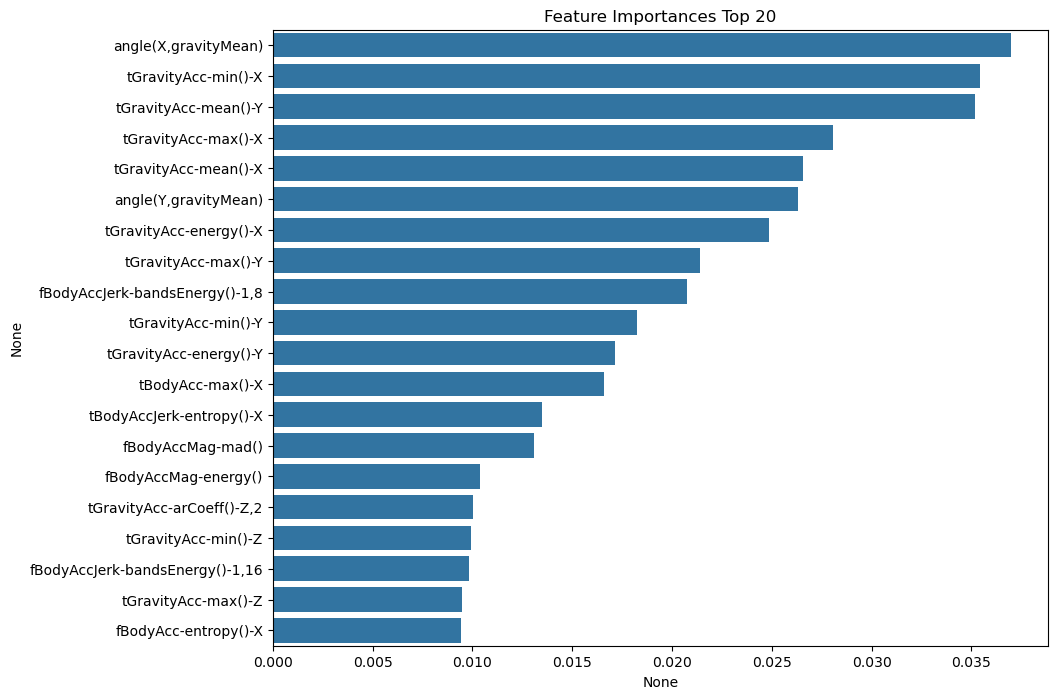

In [30]:
# 배깅 - 랜덤 포레스트 
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1. 데이터 로드 (앞서 만든 함수 활용)
X_train, X_test, y_train, y_test = get_human_dataset()

# 2. 기본 랜덤 포레스트 학습 및 평가
rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
print(f'기본 랜덤 포레스트 정확도: {accuracy_score(y_test, pred):.4f}')

# 3. GridSearchCV를 이용한 하이퍼 파라미터 튜닝
# n_jobs=-1을 추가하여 모든 CPU 코어를 사용 (속도 향상)
params = {
    'max_depth': [8, 16, 24],
    'min_samples_leaf': [1, 6, 12],
    'min_samples_split': [2, 8, 16]
}

rf_clf_base = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf_base, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train.values.ravel())

print(f'최적 하이퍼 파라미터: \n{grid_cv.best_params_}')
print(f'최고 평균 정확도: {grid_cv.best_score_:.4f}')

# 4. 최적 파라미터로 재학습 및 최종 테스트 데이터 평가
best_rf_clf = grid_cv.best_estimator_
best_rf_clf.fit(X_train, y_train)
final_pred = best_rf_clf.predict(X_test)
print(f'튜닝 후 최종 테스트 정확도: {accuracy_score(y_test, final_pred):.4f}')

# 5. 피처 중요도 시각화 (Top 20)
ftr_importances_values = best_rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 8))
plt.title('Feature Importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [33]:
#GBM
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train,X_test,y_train,y_test = get_human_dataset()
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train,y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test,gb_pred)

print('GBM 정확도: {0: .4f}'.format(gb_accuracy)) 
print ("GBM 수행 시간: {0: .1f}초".format(time.time() - start_time))

GBM 정확도:  0.9376
GBM 수행 시간:  1449.2초


In [39]:
import xgboost as xgb
from xgboost import XGBClassifier

dataset = load_breast_cancer()
features=dataset.data
labels = dataset.target
cancer_df=pd.DataFrame(data=features,columns=dataset.feature_names)
cancer_df['target']=labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [36]:
X_features=cancer_df.iloc[:,:-1]
y_label=cancer_df.iloc[:,-1]

#1. 전체 데이터에서 80%를 학습용(Train), 20%를 테스트용(Test)으로 분리
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, test_size=0.2, random_state=156
)

# 2. 위에서 얻은 학습용(X_train_all) 80%를 다시 9:1로 분리
# 이제 X_train은 진짜 학습용, X_val은 검증용이 됩니다.
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=156
)

print(f"전체 데이터 개수: {cancer.data.shape[0]}")
print(f"최종 학습용 개수: {X_train.shape[0]}")
print(f"검증용(모의고사) 개수: {X_val.shape[0]}")
print(f"테스트용(수능) 개수: {X_test.shape[0]}")

전체 데이터 개수: 569
최종 학습용 개수: 455
검증용(모의고사) 개수: 46
테스트용(수능) 개수: 114


In [48]:
import xgboost as xgb
import numpy as np

# 1. DMatrix 생성: .values를 붙여서 NumPy 2.0 호환성 문제 해결
# label에 데이터프레임을 그대로 넣으면 에러가 날 수 있으므로 .values를 꼭 붙여주세요.
dtr = xgb.DMatrix(data=X_tr, label=y_tr.astype(float))
dval = xgb.DMatrix(data=X_val, label=y_val.astype(float))
dtest = xgb.DMatrix(data=X_test, label=y_test.astype(float))

# params 설정
# 주의: 'max_depth ' 처럼 공백이 들어가면 안 됩니다!
params = { 
    'max_depth': 3, 
    'eta': 0.05, 
    'objective': 'binary:logistic', 
    'eval_metric': 'logloss' 
}
num_rounds = 400

# 2. 검증 데이터 세트 지정
evals = [(dtr, 'train'), (dval, 'eval')]

# 3. 모델 학습 (오타 수정: evavls -> evals)
xgb_model = xgb.train(
    params=params,
    dtrain=dtr,
    num_boost_round=num_rounds,
    early_stopping_rounds=50,
    evals=evals,
  verbose_eval=False  # 로그 안 나오게 함
)

# 4. 예측 (확률값 반환)
pred_probs = xgb_model.predict(dtest)
print('예측 확률 10개:', np.round(pred_probs[:10], 3))

# 0.5 기준 이진 분류
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측 결과 10개:', preds[:10])

예측 확률 10개: [0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측 결과 10개: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [59]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# 1. 모델 객체 생성 시점에 조기 중단(early_stopping_round)을 넣습니다.
# 최신 버전에서는 fit이 아니라 여기서 정의하는 것이 표준입니다.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05, 
                              early_stopping_round=50) # 여기서 설정!

# 2. 검증 세트 지정
evals = [(X_tr, y_tr), (X_val, y_val)]

# 3. 학습 시작
# fit() 안의 early_stopping_rounds는 삭제하고, 대신 eval_metric과 eval_set만 남깁니다.
# 로그 출력 간격은 callbacks=[log_evaluation(period=50)] 형태로 조절할 수 있습니다.
lgbm_wrapper.fit(
    X_tr, y_tr, 
    eval_metric="logloss", 
    eval_set=evals,
)

# 4. 예측
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 251, number of negative: 158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.613692 -> initscore=0.462858
[LightGBM] [Info] Start training from score 0.462858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [6]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# 1. 목적 함수: (x^2 - 20y)의 최솟값 찾기
def objective_func(search_space):
    x, y = search_space['x'], search_space['y']
    retval = x**2 - 20*y
    return {'loss': retval, 'status': STATUS_OK} # 딕셔너리 형태 권장

# 2. 검색 공간
space = {
    'x': hp.quniform('x', -10, 10, 1),
    'y': hp.quniform('y', -15, 15, 1)
}

# 3. 최적화 실행
trials = Trials()
best = fmin(fn=objective_func, space=space, algo=tpe.suggest, 
            max_evals=20, trials=trials, rstate=np.random.default_rng(seed=0))

print(f"최적의 파라미터: {best}")

100%|██████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1231.83trial/s, best loss: -296.0]
최적의 파라미터: {'x': np.float64(2.0), 'y': np.float64(15.0)}


In [9]:
import pandas as pd

losses = [loss_dict['loss'] for loss_dict in trials.results]

result_df = pd.DataFrame({'x':trials.vals['x'],'y':trials.vals['y'],'losses':losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


In [ ]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# 1. 검색 공간 설정 (설계도)
xgb_search_space = {
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
}

# 2. 목적 함수 정의 (실제 학습과 평가가 일어나는 곳)
def objective_func(search_space):
    # 주의: 실수형으로 들어오는 값을 정수형 파라미터에 넣을 때 int() 변환 필수!
    xgb_clf = XGBClassifier(
        n_estimators=100, # 속도를 위해 100개만 사용
        max_depth=int(search_space['max_depth']), 
        min_child_weight=int(search_space['min_child_weight']),
        learning_rate=search_space['learning_rate'],
        colsample_bytree=search_space['colsample_bytree'],
        eval_metric='logloss'
    )
    
    # 교차 검증으로 정확도 계산 (cv=3)
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
    
    # fmin은 최솟값을 찾으므로 정확도 평균에 -1을 곱해서 반환
    return {'loss': -1 * np.mean(accuracy), 'status': STATUS_OK}

# 3. 최적화 실행
trials = Trials()
best = fmin(fn=objective_func, space=xgb_search_space, algo=tpe.suggest, 
            max_evals=50, trials=trials, rstate=np.random.default_rng(seed=9))

print('최적의 파라미터:', best)